In [1]:
library(phyloseq)

library(data.table)

library(stringr)

library(dplyr)

library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## process taxonomy

In [5]:
df = read.csv('lineages_wol1.txt', sep=';', header = FALSE, col.names = c('genome_id_domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus','Species'))
df$genome_id <- str_split(df$genome_id_domain, '\t', simplify=TRUE)[, 1]
df$Kingdom <- str_split(df$genome_id_domain, '\t', simplify=TRUE)[, 2]

df = df[, !names(df) == 'genome_id_domain']
df <- df[, c("genome_id", "Kingdom", setdiff(names(df), c("genome_id", "Kingdom")))]

any(is.na(df$species)) # no NA in species 

# formatting the taxonomy table 
df$species = str_replace(df$Species, 's__', '')
rownames(df) = df$genome_id
df$genome_id <- NULL
# df

[1] FALSE

## create metadata

In [6]:
md <- data.frame(
  `source` = c("infant_gut"),
  row.names = c("MI_10_metaG") 
)

md

,source
,<chr>
MI_10_metaG,infant_gut


## load feature table

In [7]:
feature_table <- read.table(file = "./metag_tutorial_out/features/MI_10_metaG.tsv", sep = "\t", header = T, row.names = 1, 
                  skip = 0, comment.char = "")
taxonomy <- df
metadata <- md

## build phyloseq object

In [8]:
OTU = otu_table(as.matrix(feature_table), taxa_are_rows = TRUE)
TAX = tax_table(as.matrix(taxonomy))
SAMPLE = sample_data(metadata)
ps = phyloseq(OTU, TAX, SAMPLE)

## plot relative abundance

In [9]:
options(repr.plot.width = 8, repr.plot.height = 12, repr.plot.res = 100)

`summarise()` has grouped output by 'Sample', 'source'. You can override using
the `.groups` argument.


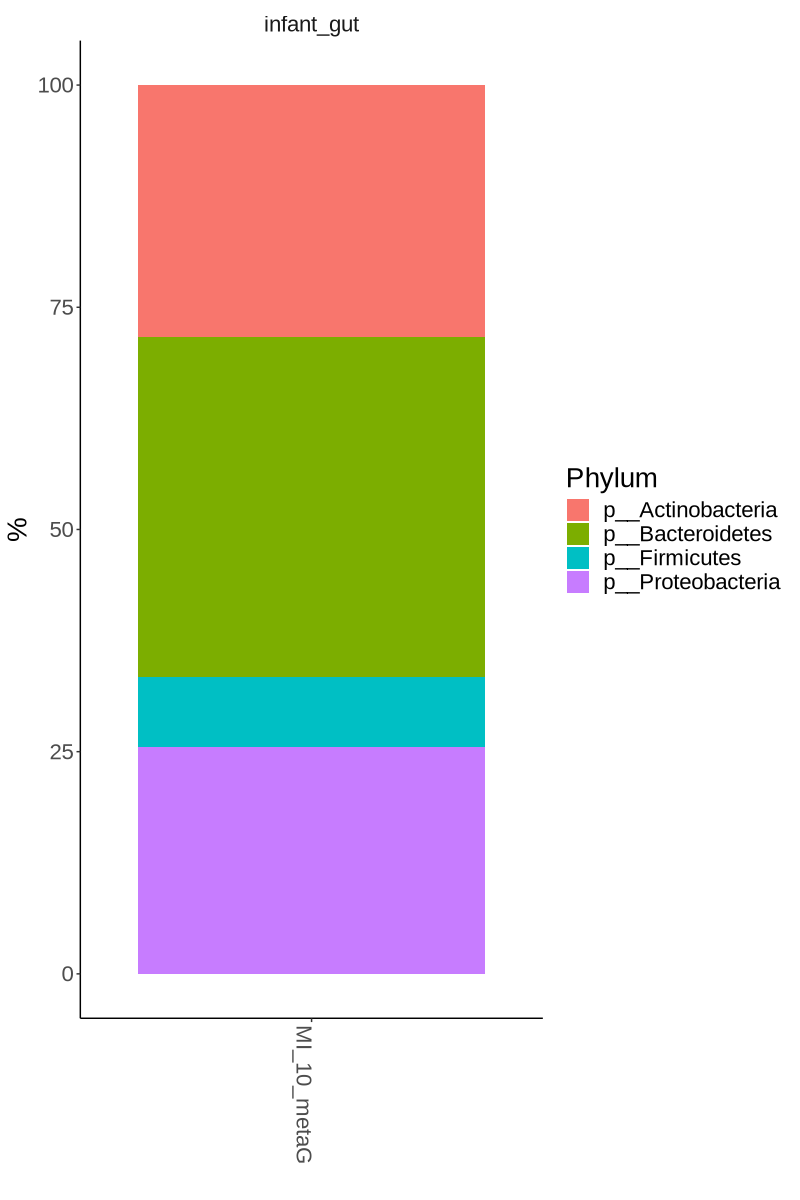

In [10]:
ps.rel = transform_sample_counts(ps, function(x) x/sum(x)*100)
# agglomerate taxa
glom <- tax_glom(ps.rel, taxrank = 'Phylum', NArm = FALSE)
ps.melt <- psmelt(glom)
                                 
# change to character for easy-adjusted level
ps.melt$Phylum <- as.character(ps.melt$Phylum)

ps.melt <- ps.melt %>%
  group_by(source, Phylum) %>%
  mutate(median=median(Abundance))
# select group median > 1
keep <- unique(ps.melt$Phylum[ps.melt$median > 1])
ps.melt$Phylum[!(ps.melt$Phylum %in% keep)] <- "< 1%"
#to get the same rows together
ps.melt_sum <- ps.melt %>%
  group_by(Sample,source,Phylum) %>%
  summarise(Abundance=sum(Abundance))

ggplot(ps.melt_sum, aes(x = Sample, y = Abundance, fill = Phylum)) + 
  geom_bar(stat = "identity", aes(fill=Phylum)) + 
  labs(x="", y="%") +
  facet_wrap(~source, scales= "free_x", nrow=1) +
  theme_classic() + 
  theme(strip.background = element_blank(), 
        axis.text.x.bottom = element_text(angle = -90),
        text = element_text(size = 20))

`summarise()` has grouped output by 'Sample', 'source'. You can override using
the `.groups` argument.


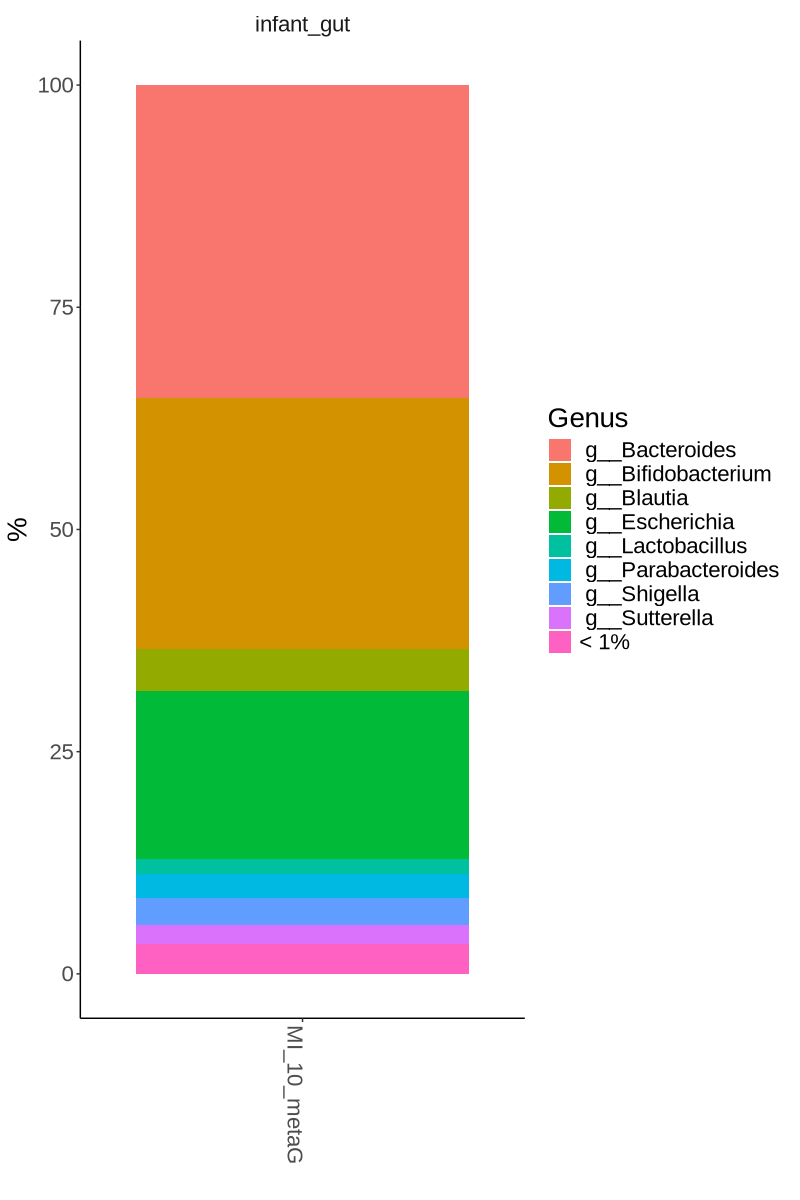

In [11]:
ps.rel = transform_sample_counts(ps, function(x) x/sum(x)*100)
# agglomerate taxa
glom <- tax_glom(ps.rel, taxrank = 'Genus', NArm = FALSE)
ps.melt <- psmelt(glom)
                                 
# change to character for easy-adjusted level
ps.melt$Genus <- as.character(ps.melt$Genus)

ps.melt <- ps.melt %>%
  group_by(source, Genus) %>%
  mutate(median=median(Abundance))
# select group median > 1
keep <- unique(ps.melt$Genus[ps.melt$median > 1])
ps.melt$Genus[!(ps.melt$Genus %in% keep)] <- "< 1%"
#to get the same rows together
ps.melt_sum <- ps.melt %>%
  group_by(Sample,source,Genus) %>%
  summarise(Abundance=sum(Abundance))

ggplot(ps.melt_sum, aes(x = Sample, y = Abundance, fill = Genus)) + 
  geom_bar(stat = "identity", aes(fill=Genus)) + 
  labs(x="", y="%") +
  facet_wrap(~source, scales= "free_x", nrow=1) +
  theme_classic() + 
  theme(strip.background = element_blank(), 
        axis.text.x.bottom = element_text(angle = -90),
        text = element_text(size = 20))